In [1]:
import numpy as np
import matplotlib.pyplot as plt
from classy import Class
import scienceplots
from scipy.interpolate import interp1d

plt.style.use(['science', 'no-latex'])
plt.rcParams.update({
    # Figure
    'figure.figsize': (6.8, 4.2),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,

    # Lines and markers
    'lines.linewidth': 1.5,
    'lines.markersize': 5,

    # Font
    'font.size': 9,
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,

    # Axes
    'axes.linewidth': 1.0,
    'axes.grid': True,
    'grid.alpha': 0.3,

    # Ticks
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 4,
    'ytick.major.size': 4,

    # Legend
    'legend.frameon': False,

    # Text rendering (LaTeX)
    # 'text.usetex': True,               # Optional: needs LaTeX installed
    # 'text.latex.preamble': r'\usepackage{amsmath,amssymb}',  # Optional
})

In [2]:
def aa(L, z_ini=99):
    a_ini = 1 / (1+ z_ini)
    return np.linspace(a_ini, 1, L)

def zz(L, z_ini=99):
    return np.linspace(z_ini, 0, L)

In [3]:
# deltalna = 7.5e-4
# lna_start = -5
# lna_end = 0.25
# N = int((lna_end - lna_start) / deltalna) + 1

# lna_smg =   np.linspace(lna_start, lna_end, N)
# DeltaM2 =   np.linspace(1e-4, 1e-4, N)
# Dkin =      np.linspace(1e-4, 1e-4, N)
# cs2 =       np.linspace(1., 1., N)

# # Stack the arrays column-wise and save
# data = np.column_stack((lna_smg, DeltaM2, Dkin, cs2))
# np.savetxt("../stable_params_input/gr.dat", data, delimiter=" ")

In [4]:
kk = np.geomspace(1e-4, 10, num=10)

In [5]:
gral_pars = {
    # Reference Cosmology from EuclidEmuII
    'H0'      : 67,
    'Omega_b' : 0.049,
    'Omega_cdm' : '0.27 - Omega_ncdm',

    'A_s' : 2.1e-9,
    'n_s' : 0.96,
    'alpha_s' : 0,
    'k_pivot' : 0.05,

    # 'N_ur' : 0,
    # 'N_ncdm' : 1,
    # 'deg_ncdm' : 3,
    # 'm_ncdm' : 0.058/3,

    'evolver': 0,
    'output': 'mPk, tCl',
    'P_k_max_1/Mpc': 3.0,
    'z_max_pk': 49,
    'k_output_values': ','.join([str(k) for k in kk])
}
w0wa_mochi = gral_pars | {
    # MG MODEL
    # Disable cosmological constant and DE fluid
    'Omega_Lambda': 0,
    'Omega_fld': 0,
    # Enable mochiclass
    'Omega_smg': -1,
    # Choose the model
    'root': 'output/w0wa_mochi',
    'gravity_model': 'stable_params',
    'smg_file_name': '../stable_params_input/gr.dat',
    'parameters_smg': '1e-10',
    'expansion_model': 'w0wa',
    'expansion_smg': '0.67, -1., 0.', #Lambda, w0, wa
    # CLASS evolver
    'evolver': 0,
    'method_qs_smg': 'automatic'
}

w0wa_class = gral_pars | {
    # MG MODEL
    # Disable cosmological constant 
    'Omega_Lambda': 0,
    # Dark energy fluid parameters
    'w0_fld' : -1,
    'wa_fld' : 0,
    'root': 'output/w0wa_class',
    # CLASS evolver
    'evolver': 0
}

hs_pars = gral_pars | {
    # MG MODEL
    # Disable cosmological constant and DE fluid
    'Omega_Lambda': 0,
    'Omega_fld': 0,
    # Enable mochiclass
    'Omega_smg': -1,
    # Choose the model
    'gravity_model': 'stable_params',
    'smg_file_name': '../stable_params_input/hs_fr_stable_params_fr0_1em4_n_1_mathematica.dat',
    'parameters_smg': '1e-10',
    'expansion_model': 'wext',
    # CLASS evolver
    'evolver': 0,
    'method_qs_smg': 'automatic'
}


In [6]:
cosmologies = {}

cosmologies['w0wa_class'] = Class()
cosmologies['w0wa_class'].set(w0wa_class)
cosmologies['w0wa_class'].compute()


# cosmologies['w0wa_mochi'] = Class()
# cosmologies['w0wa_mochi'].set(w0wa_mochi)
# cosmologies['w0wa_mochi'].compute()


In [8]:
def calc_cosmo(pars):
    cosmo = Class()
    cosmo.set(pars)
    cosmo.compute()

    # Get the perturbations
    bk = cosmo.get_background()
    pt = cosmo.get_perturbations()
    
    cosmo.struct_cleanup()
    cosmo.empty()
    return bk, pt


In [9]:
cosmo_w0wa_class = calc_cosmo(w0wa_class)
cosmo_w0wa_mochi = calc_cosmo(w0wa_mochi)

In [10]:
w0wa_a_class = 1/(1+cosmo_w0wa_class[0]['z'])
w0wa_a_mochi = 1/(1+cosmo_w0wa_mochi[0]['z'])

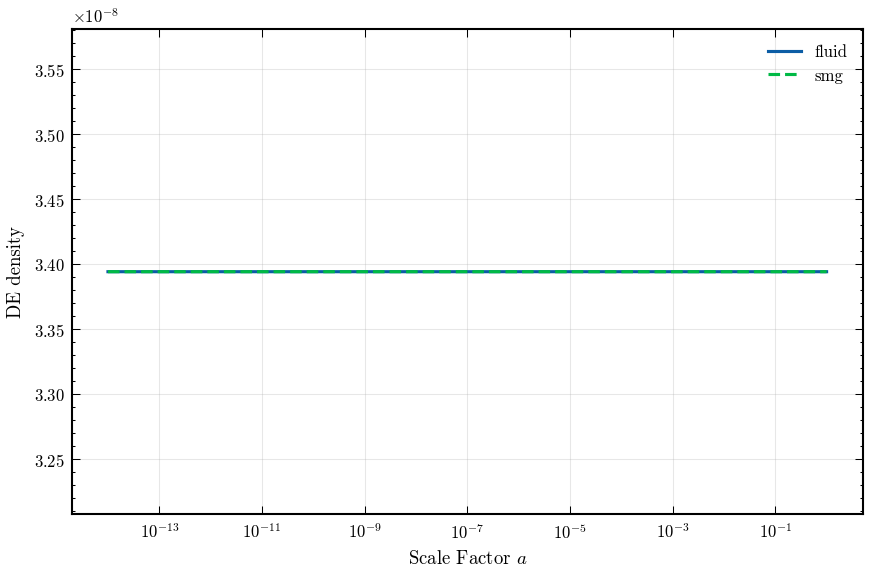

In [11]:
fig, ax = plt.subplots()

ax.semilogx(w0wa_a_class, cosmo_w0wa_class[0]['(.)rho_fld'], label='fluid')
ax.semilogx(w0wa_a_mochi, cosmo_w0wa_mochi[0]['(.)rho_smg'], '--', label='smg')

# ax.invert_xaxis()
ax.set_ylabel('DE density')
ax.set_xlabel('Scale Factor $a$')
ax.legend()


In [12]:
print(cosmo_w0wa_class[0].keys(),'\n',cosmo_w0wa_mochi[0].keys())

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_ncdm[0]', '(.)p_ncdm[0]', '(.)rho_fld', '(.)w_fld', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f', 'gr.fac. D2', 'gr.fac. f2', 'gr.fac. D3a', 'gr.fac. f3a', 'gr.fac. D3b', 'gr.fac. f3b', 'gr.fac. D3c', 'gr.fac. f3c']) 
 dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_ncdm[0]', '(.)p_ncdm[0]', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f', 'gr.fac. D2', 'gr.fac. f2', 'gr.fac. D3a', 'gr.fac. f3a', 'gr.fac. D3b', 'gr.fac. f3b', 'gr.fac. D3c', 'gr.fac. f3c', '(.)rho_smg', '(.)p_smg', '(.)p_smg_prime', '(.)p_smg_prime_prime', 'M*^2_smg', 'D_M*^2_smg', 'kineticity_smg', 'braiding_smg', 'tensor_excess_smg', 

In [13]:
print(cosmo_w0wa_class[1].keys(),'\n',cosmo_w0wa_mochi[1].keys())

dict_keys([]) 
 dict_keys([])


In [14]:
cosmo_w0wa_class[1]

{}

In [15]:
cosmo_w0wa_class[1]['scalar'][0]['a']

KeyError: 'scalar'